In [1]:
from glob import glob
import os
import shutil

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA

make path for image classification

In [2]:
os.makedirs('../working/data/train_seg/idc-minus/')     
os.makedirs('../working/data/train_seg/idc-plus/')  
os.makedirs('../working/data/test_seg/idc-minus/')     
os.makedirs('../working/data/test_seg/idc-plus/')  
#os.makedirs('../working/data/val_seg/idc-minus/')     
#os.makedirs('../working/data/val_seg/idc-plus/')  

# **Image Import**
for first time run uncomment this cell
this will catagorise files into different directory
for second time run please comment this cell

In [3]:
sampling_seed=0
size_4_training=1000
img_size=75
#training_reshape=(-1, img_size, img_size, 3)

In [4]:

from glob import glob
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
train_dir='../working/data/train_seg/'
validation_dir='../working/data/val_seg/'
#train_dir='../working/data/train_seg/'  
#test_dir = '../working/data/test_seg/normal'  
test_dir = '../working/data/test_seg/'  

class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model

random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training)
class0label=np.zeros(size_4_training)
class1sample=random.sample(class1,size_4_training)
class1label=np.ones(size_4_training)

class0sample_train, class0sample_test, class0label_train, class0label_test = train_test_split(class0sample, class0label, test_size=0.3, random_state=42)
#class0sample_test,class0sample_val,  class0label_test, class0label_val = train_test_split(class0sample_test1, class0label_test1, test_size=0.3, random_state=42)
print(len(class0sample_train))
print(len(class0sample_test))
#print(len(class0sample_val))
class1sample_train, class1sample_test, class1label_train, class1label_test = train_test_split(class1sample, class1label, test_size=0.3, random_state=42)
#class1sample_test, class1sample_val, class1label_test, class1label_val = train_test_split(class1sample_test1, class1label_test1, test_size=0.3, random_state=42)
print(len(class1sample_train))
print(len(class1sample_test))
#print(len(class1sample_val))
def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
          
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            #print(outputname)

            shutil.copy(i, outputname)
             
            #print(status2)
            
            j=j+1
            if j==120000:
                break
            
   
class0train_path='../working/data/train_seg/idc-minus/'
class1train_path='../working/data/train_seg/idc-plus/'
class0test_path='../working/data/test_seg/idc-minus/'
class1test_path='../working/data/test_seg/idc-plus/'
#class0val_path='../working/data/val_seg/idc-minus/'
#class1val_path='../working/data/val_seg/idc-plus/'

read_and_save_data(class0train_path,class0sample_train)

read_and_save_data(class1train_path,class1sample_train)


read_and_save_data(class0test_path,class0sample_test)
read_and_save_data(class1test_path,class1sample_test)


#read_and_save_data(class0val_path,class0sample_val)
#read_and_save_data(class1val_path,class1sample_val)


['../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png', '../input/breast-histopathology-images/IDC_regular_ps50_idx5/102

Image classification

In [5]:
import os #Operating System
import sys #System
# train_generator = train_datagen.flow(x_train, y_train, batch_size =)
# val_generator = val_datagen.flow(x_val, y_val, batch_size = 64)
# test_generator=test_datagen.flow(x_test,y_test,batch_size = 64)

In [6]:
import os
import cv2
def readImage(path, tag):
    j=0
    image_data = []
    label=[]
    for i in os.listdir(path):
        imgname=path+i
        #print(imgname)
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (128,128), interpolation=cv2.INTER_LINEAR)
        image_data.append(img_resized)
        label.append(tag)
        #print(img[1])
        j=j+1
        #if j==10:
        #    break
        
    return image_data, label

import numpy as np
from tensorflow.keras.utils import *
from sklearn.utils import shuffle

class0_train, train0_label = readImage(class0train_path, 0)
class1_train, train1_label  = readImage(class1train_path, 1)
class0_test, test0_label = readImage(class0test_path, 0)
class1_test, test1_label = readImage(class1test_path, 1)
#class0_val, val0_label = readImage(class0val_path, 0)
#class1_val, val1_label = readImage(class1val_path, 1)

def Image_array_process(class0array,label0, class1array, label1):
    class0_array=np.array(class0array)
    class1_array=np.array(class1array)
    combined_data = np.concatenate((class0_array, class1_array))
    combined_label= np.concatenate((label0,label1), axis=0)
    assert len(combined_data) == len(combined_label)
    combined_data, combined_label = shuffle(combined_data, combined_label, random_state=0)
    print(combined_data.shape)
    length=len(combined_data)
    combined_label=to_categorical(combined_label,num_classes=2)
    i=0
    for i in range(length):
        print(combined_label[i])



    #print(class0_array.shape)
    #print(combined_data.shape)
    '''
    training_reshape=(224,224,3)
    length=len(combined_data)
    print(length)
    x =[None]*length
    #print(img_data.type)
    y =np.zeros(length)
    i=0
   
    for features,label in combined_data:
        x[i]=features
        #print(x.shape)
        y[i]=label
        #print(y[i])
        i=i+1
    
            #x = np.array(x).reshape(training_reshape)
    x = np.array(x)    
    #print(x.shape)
    #y=np.array(y)
    y=y.astype(int)
    y = to_categorical(y)
    print(y)
    '''  
    return combined_data, combined_label


X_train, y_train=Image_array_process(class0_train, train0_label, class1_train, train1_label)
X_test, y_test=Image_array_process(class0_test, test0_label, class1_test, test1_label)
#X_val, y_val=Image_array_process(class0_val, val0_label, class1_val, val1_label)

(1400, 128, 128, 3)
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 

In [7]:
print(y_test)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [8]:
print(y_train)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [9]:
data_dir = "../working/idc2"
SIZE_X = SIZE_Y = img_size

train_dir='../working/data/train_seg/'
#validation_dir='../working/data/val_seg/'
test_dir = '../working/data/test_seg/' 

train_gen = tf.keras.preprocessing.image.ImageDataGenerator()
test_gen=tf.keras.preprocessing.image.ImageDataGenerator()
val_gen=tf.keras.preprocessing.image.ImageDataGenerator()

 
train_it = train_gen.flow_from_directory(train_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_it = test_gen.flow_from_directory('./data/test_seg',
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)
'''
val2_it = val_gen.flow_from_directory(validation_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)
'''

Found 1400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


'\nval2_it = val_gen.flow_from_directory(validation_dir,\n                                       class_mode = "categorical",\n                                       target_size = (SIZE_X, SIZE_Y),\n                                       color_mode="rgb",\n                                       batch_size = 12, \n                                       shuffle = False,\n                                       subset=\'validation\',\n                                       seed = 42)\n'

In [10]:
def get_features(base_model, train, validate):
    X_train = base_model.predict(train)
    y_train = train.classes

    X_val = base_model.predict(validate)
    y_val = validate.classes

    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.3, shuffle = True)
    print('Shape of X_train----->', str(X_train.shape))
    print('Shape of X_val----->', str(X_val.shape))
    print('Shape of X_test----->', str(X_test.shape))
    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [11]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
def get_models():
    ANN = Sequential()
    ANN.add(Dense(4096, input_dim = X_train.shape[1], activation = 'relu'))
    ANN.add(BatchNormalization())
    ANN.add(Dense(4096, activation='relu'))
    ANN.add(Dropout(0.2))
    ANN.add(Dense(2096, activation='relu'))
    #ANN.add(Dense(16, activation='relu'))
    #ANN.add(Dense(8, activation='relu'))
    ANN.add(Dense(len(train_it.class_indices), activation='sigmoid'))
    

    opt = Adam(learning_rate=0.001)
    ANN.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
 
    KNN = KNeighborsClassifier()
    
    SVM = SVC(kernel = 'linear')
    
    RF = RandomForestClassifier(n_estimators = 50)
    
    ADB = AdaBoostClassifier()
    
    XGB = XGBClassifier(n_estimators = 50, use_label_encoder=False)
    
    print("Defined------->")
    print("ANN -------->", "(128x64x32x16x8)")
    print("KNeighborsClassifier()")
    print("SVC(kernel = 'linear')")
    print("RandomForestClassifier(n_estimators = 50)")
    print("AdaBoostClassifier()")
    print("XGBClassifier(n_estimators = 50)")
    
    return (ANN, KNN, SVM, RF, ADB, XGB)

In [12]:
def reshape_data(X_train, X_val, X_test):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    print("Shape after reshaping------->")
    print("X train------->", str(X_train.shape))
    print("X val-------->", str(X_val.shape))
    print("X test-------->", str(X_test.shape))
    
    return (X_train, X_val, X_test)

In [13]:
from tensorflow.keras.utils import to_categorical
def fit_ANN(model, X_train, y_train, X_val, y_test):
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1), ModelCheckpoint('ANN.hdf5', save_best_only=True)]
    y_train=to_categorical(y_train)
    y_test=to_categorical(y_test)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_test), epochs=10, verbose=1, callbacks=callbacks)
    return model

def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
def get_accuracy_metrics_for_ANN(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.summary()
    plot_model(model, to_file='ANN.png', show_shapes=True,show_layer_names=True)
    Image(filename='ANN.png') 
    #y_train=np.argmax(y_train, axis=1)
    #y_test=np.argmax(y_test, axis=1)
    #y_val=np.argmax(y_val, axis=1)
    y_train_pred=np.argmax(model.predict(X_train),axis=1)
    y_test_pred=np.argmax(model.predict(X_test),axis=1)
    y_val_pred=np.argmax(model.predict(X_val),axis=1)
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, np.argmax(model.predict(X_train), axis = 1))*100), "%")
    
    print("Val accuracy Score--------->")
    #val_pred = np.argmax(model.predict(X_val), axis = 1)
    print("{0:.3f}".format(accuracy_score(y_val, y_val_pred)*100), "%")
    
    #predicted =  np.argmax(model.predict(X_test), axis = 1)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_test_pred)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_test_pred)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    cf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [16]:
def fit_KNN_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    pca = PCA(n_components=1000)
    randlist = random.sample(range(0, X_train.shape[0]), 1000)
    if(X_train.shape[1] > 10000):
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)

    model.fit(X_train, y_train)
    get_accuracy_metrics(model, X_train[randlist, :], y_train[randlist], X_val, y_val, X_test, y_test)
    
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, model.predict(X_train))*100), "%")
    
    print("Val accuracy Score--------->")
    val_pred = model.predict(X_val)
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    predicted =  model.predict(X_test)
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

# Resnet50

In [17]:
#base_model = VGG16(include_top=False, input_shape=(SIZE_X, SIZE_Y, 2), weights='imagenet')
#base_Neural_Net= MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
# Fixed for idc+/- classes
NUM_CLASSES = 2

# Fixed for rgb color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'sigmoid'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

from keras.applications import resnet
base_model=resnet.ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
                   
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
model.summary()

2022-05-11 16:19:37.525177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 16:19:37.639488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 16:19:37.640294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 16:19:37.641499: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

# here is the input place of data

In [18]:
X_train, X_val, X_test, y_train, y_val, y_test = get_features(model, train_it, validate_it)

2022-05-11 16:19:42.000183: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-11 16:19:44.012889: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Shape of X_train-----> (1400, 2048)
Shape of X_val-----> (420, 2048)
Shape of X_test-----> (180, 2048)


In [19]:
X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
ANN, KNN, SVM, RF, ADB, XGB = get_models()

ANN = fit_ANN(ANN, X_train, y_train, X_val, y_val)

Shape after reshaping------->
X train-------> (1400, 2048)
X val--------> (420, 2048)
X test--------> (180, 2048)
Defined------->
ANN --------> (128x64x32x16x8)
KNeighborsClassifier()
SVC(kernel = 'linear')
RandomForestClassifier(n_estimators = 50)
AdaBoostClassifier()
XGBClassifier(n_estimators = 50)
Epoch 1/10
44/44 [==============================] - 1s 11ms/step - loss: 1.8106 - accuracy: 0.7221 - val_loss: 0.5112 - val_accuracy: 0.7714
Epoch 2/10
44/44 [==============================] - 0s 7ms/step - loss: 0.4292 - accuracy: 0.8129 - val_loss: 0.4752 - val_accuracy: 0.7833
Epoch 3/10
44/44 [==============================] - 0s 9ms/step - loss: 0.3753 - accuracy: 0.8529 - val_loss: 0.4944 - val_accuracy: 0.7833
Epoch 4/10
44/44 [==============================] - 0s 8ms/step - loss: 0.3301 - accuracy: 0.8579 - val_loss: 0.5556 - val_accuracy: 0.7619
Epoch 5/10
44/44 [==============================] - 0s 7ms/step - loss: 0.2699 - accuracy: 0.8893 - val_loss: 0.5965 - val_accuracy: 0.7

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              8392704   
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2096)              8587312   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4194      
Total params: 33,781,906
Trainable params: 33,773,714
Non-trainable params: 8,192
________________________________________

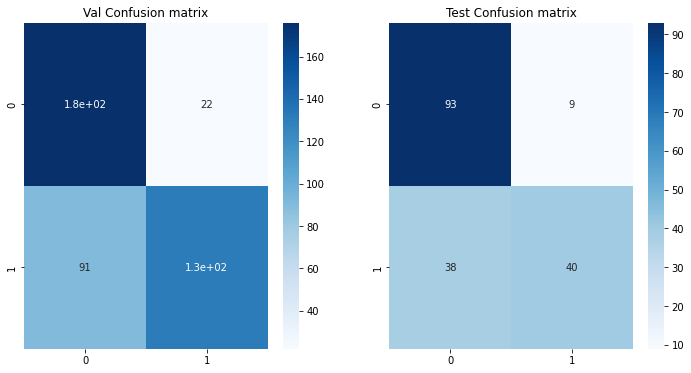

In [20]:
get_accuracy_metrics_for_ANN(ANN, X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
81.800 %
Val accuracy Score--------->
75.238 %
Test accuracy Score--------->
76.111 %
F1 Score--------------->
76.001 %
Cohen Kappa Score------------->
50.988 %
Recall-------------->
76.111 %
Precision-------------->
76.011 %


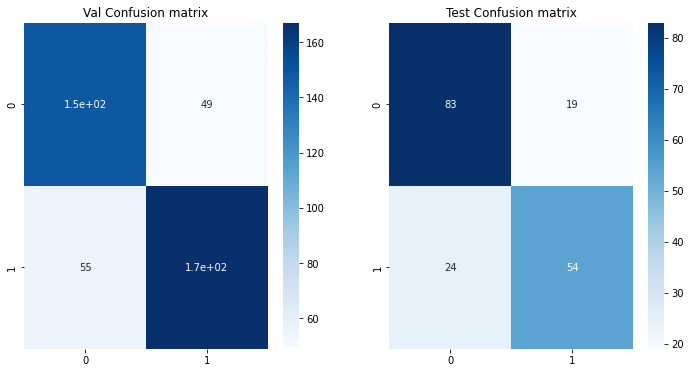

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

fit_KNN_metrics(KNN, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
75.476 %
Test accuracy Score--------->
73.333 %
F1 Score--------------->
73.181 %
Cohen Kappa Score------------->
45.205 %
Recall-------------->
73.333 %
Precision-------------->
73.194 %


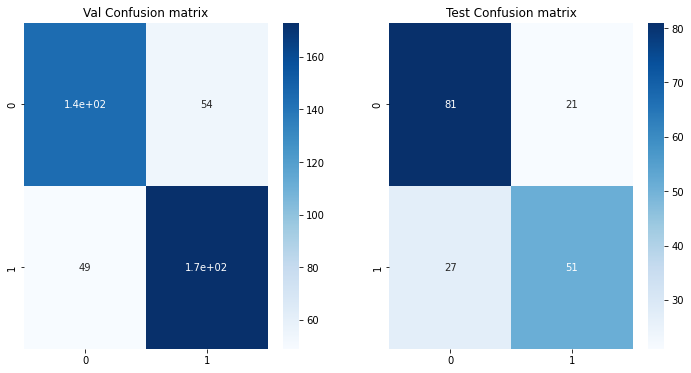

In [22]:
SVM = fit_model(SVM, X_train_scaled, y_train)
get_accuracy_metrics(SVM, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
78.571 %
Test accuracy Score--------->
77.778 %
F1 Score--------------->
77.596 %
Cohen Kappa Score------------->
54.198 %
Recall-------------->
77.778 %
Precision-------------->
77.732 %


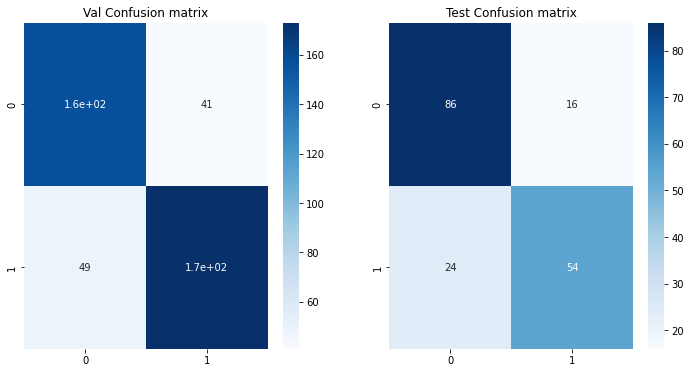

In [23]:
RF = fit_model(RF, X_train, y_train)
get_accuracy_metrics(RF,  X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
87.214 %
Val accuracy Score--------->
75.238 %
Test accuracy Score--------->
75.000 %
F1 Score--------------->
74.827 %
Cohen Kappa Score------------->
48.552 %
Recall-------------->
75.000 %
Precision-------------->
74.887 %


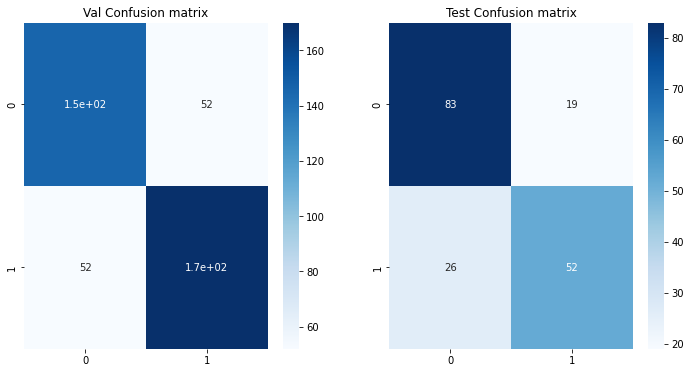

In [24]:
ADB = fit_model(ADB, X_train, y_train)
get_accuracy_metrics(ADB,  X_train, y_train, X_val, y_val, X_test, y_test)

Train accuracy Score------------>
100.000 %
Val accuracy Score--------->
77.143 %
Test accuracy Score--------->
80.556 %
F1 Score--------------->
80.466 %
Cohen Kappa Score------------->
60.106 %
Recall-------------->
80.556 %
Precision-------------->
80.504 %


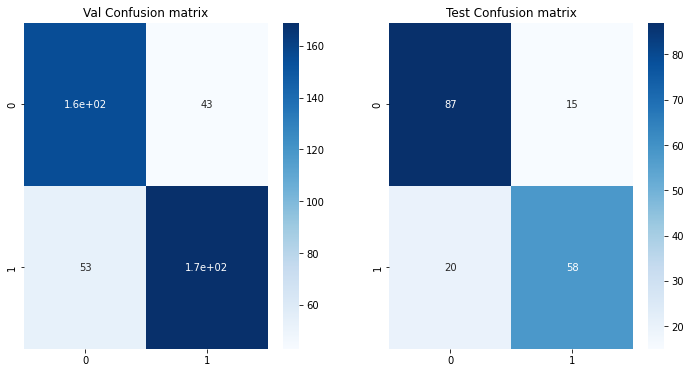

In [25]:
XGB = fit_model(XGB, X_train, y_train)
get_accuracy_metrics(XGB,  X_train, y_train, X_val, y_val, X_test, y_test)